In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [2]:
###### Espace latent 2 dimensions

latent_dims = 8
num_epochs = 20
batch_size = 1
capacity = 128
learning_rate = 1e-4
variational_beta = 0.001
# use_gpu = True



# # 10-d Espace latent en 10 dimensions, qui correspond à un Autoencoder simple (à comparer avec le VAE 
# et un espace latent de 2 dimensions)
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

# Chargement des données 


In [3]:
import os
import descriptors
import numpy as np

dict_r = np.load('data_dict.npy', allow_pickle=True).item()

train_db = np.zeros([len(dict_r['env']),2,750])


i = 0
for sample in dict_r['env']:
    train_db[i,:,:] = sample
    i+=1
    
MAX1 = np.max(train_db[:,0,:])
MAX2 = np.max(train_db[:,1,:])
train_db[:,0,:] /= MAX1
train_db[:,1,:] /= MAX2
train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))
# train_db = train_db.reshape(-1,1,750*2)

print(train_db.shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

(279, 2, 750)


# Defintion du VAE 

Kernel Size = 4 papier qui explique pourquoi: https://distill.pub/2016/deconv-checkerboard/

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
#         self.conv1 = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=c, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(c)) # out: c, 2, 750
#         self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(2*c)) # out: c*2, 2, 750
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=c, kernel_size=3, stride=1, padding=1) # out: c, 2, 750
        self.conv2 = nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=3, stride=1, padding=1) # out: c*2, 2, 750
        self.fc_mu = nn.Linear(in_features=2*c*2*750, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=2*c*2*750, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=2*c*2*750)
#         self.conv2 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(c))
#         self.conv1 = nn.Sequential(nn.ConvTranspose1d(in_channels=c, out_channels=1, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(1))
        self.conv2 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.ConvTranspose1d(in_channels=c, out_channels=1, kernel_size=3, stride=1, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 2*750) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.mse_loss(recon_x.view(-1, batch_size*2*750), x.view(-1, batch_size*2*750), reduction='mean')
    variational_beta = 0.001
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence, recon_loss, variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

# device = torch.device("cuda:0")
# vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 9797905


# Entrainement

In [5]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []
train_loss_avg2 = []
train_loss_avg3 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    train_loss_avg2.append(0)
    train_loss_avg3.append(0)
    num_batches = 0
    
    for image_batch in train_loader:

        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0])
        image_batch = image_batch.view(batch_size,1,2*750)
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch.float())
        
        # reconstruction error
        loss, loss2, loss3 = vae_loss(image_batch_recon, image_batch.float(), latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        train_loss_avg2[-1] += loss2.item()
        train_loss_avg3[-1] += loss3.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    train_loss_avg2[-1] /= num_batches
    train_loss_avg3[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f (l2 = %f, l3 = %f)' % (epoch+1, num_epochs, train_loss_avg[-1], train_loss_avg2[-1], train_loss_avg3[-1]))

Training ...
Epoch [1 / 20] average reconstruction error: 0.043700 (l2 = 0.035095, l3 = 0.008605)
Epoch [2 / 20] average reconstruction error: 0.017458 (l2 = 0.009746, l3 = 0.007712)
Epoch [3 / 20] average reconstruction error: 0.015414 (l2 = 0.008505, l3 = 0.006909)
Epoch [4 / 20] average reconstruction error: 0.012814 (l2 = 0.007158, l3 = 0.005656)
Epoch [5 / 20] average reconstruction error: 0.011964 (l2 = 0.006811, l3 = 0.005153)
Epoch [6 / 20] average reconstruction error: 0.010965 (l2 = 0.006017, l3 = 0.004948)
Epoch [7 / 20] average reconstruction error: 0.010077 (l2 = 0.005650, l3 = 0.004426)
Epoch [8 / 20] average reconstruction error: 0.009016 (l2 = 0.004956, l3 = 0.004060)
Epoch [9 / 20] average reconstruction error: 0.008836 (l2 = 0.005068, l3 = 0.003768)
Epoch [10 / 20] average reconstruction error: 0.008166 (l2 = 0.004639, l3 = 0.003528)
Epoch [11 / 20] average reconstruction error: 0.007921 (l2 = 0.004674, l3 = 0.003247)
Epoch [12 / 20] average reconstruction error: 0.00

# Affichage de la courbe de loss 

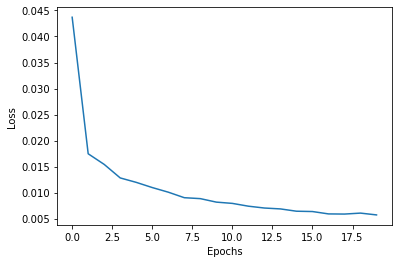

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluation du score sur le Dataset de TEST

In [8]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch in test_dataloader:
    
    with torch.no_grad():
    
        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0])
        Max_image_batch = torch.max(image_batch)
        image_batch = image_batch.view(batch_size,1,2*750)/Max_image_batch
        image_batch = image_batch.float()
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss, loss2, loss3 = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 0.010090


# Reconstruction 

Image originale


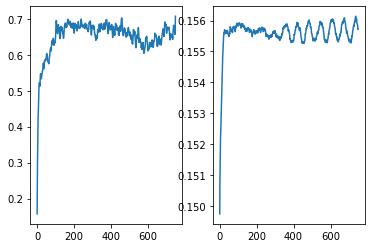

VAE reconstruction:


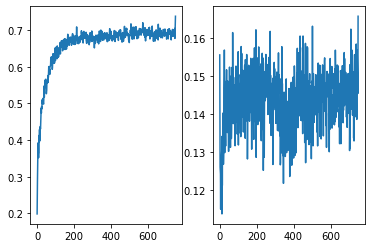

Image originale


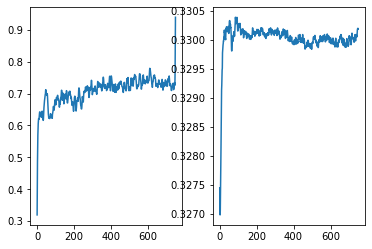

VAE reconstruction:


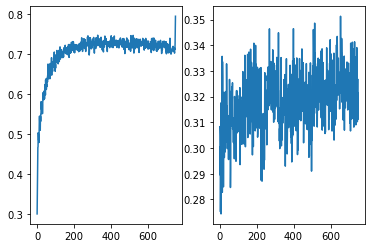

In [26]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction




images = train_db[55,:,:]
# Affichage de l'image originale
print('Image originale')

plt.figure()
plt.subplot(1,2,1)
plt.plot((images[0,:]))
plt.subplot(1,2,2)
plt.plot((images[1,:]))        
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
images_recon,a,b = vae(torch.from_numpy(images).view(batch_size,1,2*750).float())
images_recon = images_recon.detach().numpy()
plt.figure()
plt.subplot(1,2,1)
plt.plot((images_recon[0,0,0:750]))
plt.subplot(1,2,2)
plt.plot((images_recon[0,0,750:2*750]))   
plt.show()


images = train_db[8,:,:]
# Affichage de l'image originale
print('Image originale')

plt.figure()
plt.subplot(1,2,1)
plt.plot((images[0,:]))
plt.subplot(1,2,2)
plt.plot((images[1,:]))        
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
images_recon,a,b = vae(torch.from_numpy(images).view(batch_size,1,2*750).float())
images_recon = images_recon.detach().numpy()
plt.figure()
plt.subplot(1,2,1)
plt.plot((images_recon[0,0,0:750]))
plt.subplot(1,2,2)
plt.plot((images_recon[0,0,750:2*750])) 
plt.show()

In [ ]:
#Sauvergarder valeurs de l'entrainement
torch.save(model.state_dict(), 'Train_VAEconv_solordinario')



In [7]:
#charger les valeurs
vae.load_state_dict(torch.load('Train_VAEconv_solordinario'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc_mu): Linear(in_features=192000, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=192000, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=192000, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)